In [8]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [15]:
train_file_path = 'lab1_train.csv'

train_data = pd.read_csv(train_file_path, delimiter=',')

# Convert Timestamp column to datetime
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')

test_file_path = 'lab1_test.csv'

test_data = pd.read_csv(test_file_path, delimiter=',')

# Convert Timestamp column to datetime
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')

In [10]:
def visualize_sensor_data(df, window=None, sensors=None, normalized=False):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window

    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]

    # Plot each sensor in a different color
    plt.figure(figsize=(15, 8))
    for sensor in sensors:
        sensor_data = df[sensor][start_index:end_index]
        if normalized:
            sensor_data = sensor_data - sensor_data.mean()
        plt.plot(df['Timestamp'][start_index:end_index], sensor_data, label=sensor)

    plt.xlabel('Timestamp')
    plt.ylabel('Sensor Values')
    plt.title('Sensor Data Visualization')
    if len(sensors) > 15:
        plt.legend().set_visible(False)
    else:
        plt.legend()

    plt.show()

In [3]:
def principal_component_analysis(df, k):
    eigenvectors = np.zeros(shape=(df.shape[1], k))
    df = df.values.T.astype(float)

    # zero-mean the data
    for i in range(df.shape[0]):
        df[i] = df[i] - np.mean(df[i])

    # create the covariance matrix
    cov = 1 / df.shape[0] * df @ df.T

    # compute eigenvalues and eigenvectors
    evl, evec = np.linalg.eig(cov)
    d = {}
    for i in range(evl.size):
        d[evl[i]] = evec[:,i]

    # sort by eigenvalues decreasingly
    evls = np.sort(np.unique(evl))[::-1]

    # take first k eigenvectors
    for i in range(k):
        eigenvectors[:,i] = d[evls[i]]

    return eigenvectors  


def apply_principal_component_analysis(df, eigenvectors):
    projected_data = np.zeros(shape=(df.shape[0], eigenvectors.shape[1]))
    means = np.zeros(df.shape[0])
    df = df.T.values.astype(float)

    # zero-mean the data
    for i in range(df.shape[0]):
        means[i] = np.mean(df[i])
        df[i] = df[i] - means[i]

    df = df.T
    # project the data
    projected_data = df @ eigenvectors

    # reproject it back
    reprojected_data = projected_data @ eigenvectors.T

    # return the projected data, reprojected data and the normalized data
    return pd.DataFrame(reprojected_data), pd.DataFrame(projected_data), pd.DataFrame(df)

In [19]:
# Applies PCA for anomaly detection on the test data using eigenvectors from the training data
# @param train training data - we assume it is a pandas DataFrame that includes Timestamp and Normal/Attack fields
# @param test test data - we assume it is a pandas DataFrame that includes Timestamp and Normal/Attack fields
# @param k number of principal components
# @param pca_threshold the threshold for anomaly removal
# @param plot_steps plot intermediary steps
def pca_for_anomaly_detection(train, test, k, pca_threshold=None, plot_steps=False):
    #remove Timestamp and Normal/Attack fields from DataFrames
    test_without_ts = pd.DataFrame(test.values[:, 1:-1])
    train_without_ts = pd.DataFrame(train.values[:, 1:-1])
    
    # compute k eigenvectors and apply PCA
    eig = principal_component_analysis(train_without_ts,k)
    reproj_data, proj_data, norm_data = apply_principal_component_analysis(test_without_ts, eigenvectors=eig)
    
    if plot_steps:
        # plot the original normalized data
        norm_data.plot()
        plt.legend().set_visible(False)
        plt.title('Original data')
        plt.show()
        
        # plot the reprojected data
        reproj_data.plot()
        plt.legend().set_visible(False)
        plt.title('Reprojected data')
        plt.show()
    
    # use Mean-Squared Error as a metric for removing anomalies 
    mse_residuals = np.zeros(reproj_data.shape[0])
    for i in range(reproj_data.shape[0]):
        mse_residuals[i] = np.mean((reproj_data.iloc[i] - norm_data.iloc[i]) ** 2)
    
    
    # default threshold
    if pca_threshold is None:
        pca_threshold = np.mean(mse_residuals) + 2 * np.std(mse_residuals)
        
    plt.plot(mse_residuals)
    plt.axhline(y=pca_threshold, color='red', linestyle='--')
    plt.title('Residual plot on train data')
        
    # iterate through the data and find "normal" datapoints (having MSE lower than threshold)
    indices = []
    
    for i in range(norm_data.shape[0]):
        if mse_residuals[i] < pca_threshold:
            indices.append(i)
    # return the DataFrame with anomalies removed
    return test.iloc[indices],indices

In [6]:
train_data.shape

(496800, 53)

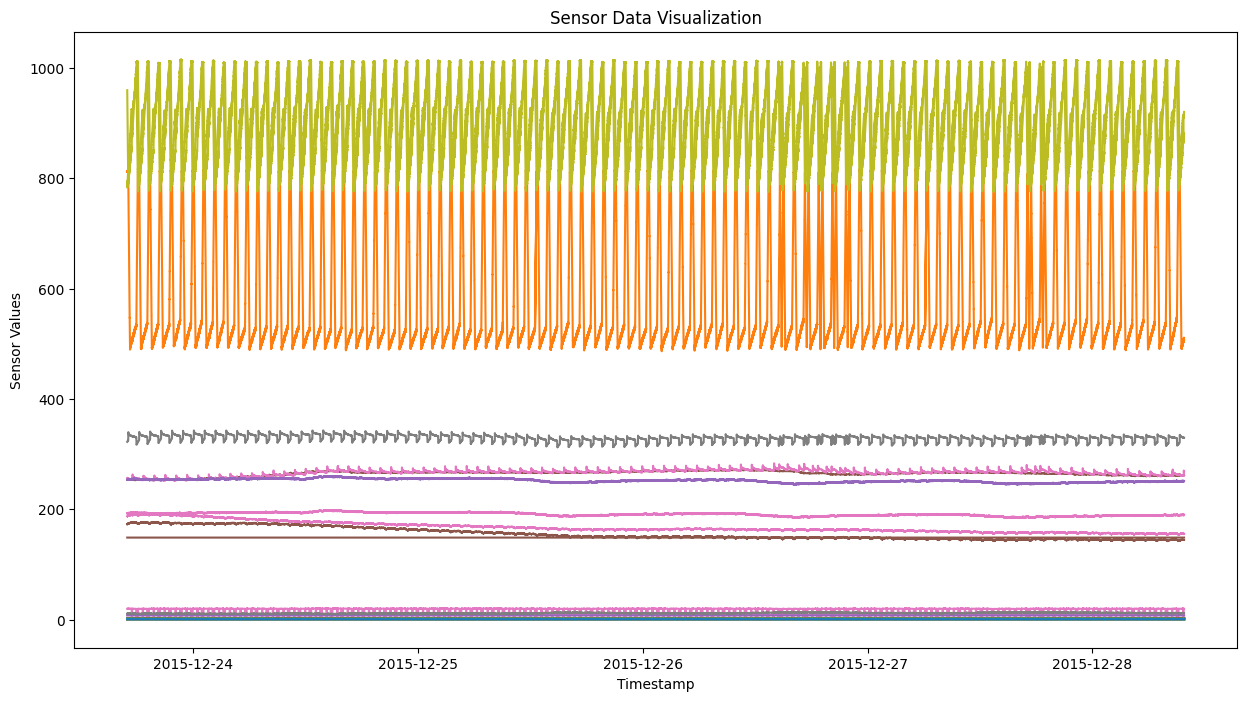

In [29]:
visualize_sensor_data(train_data,window=(90_000,496_000))

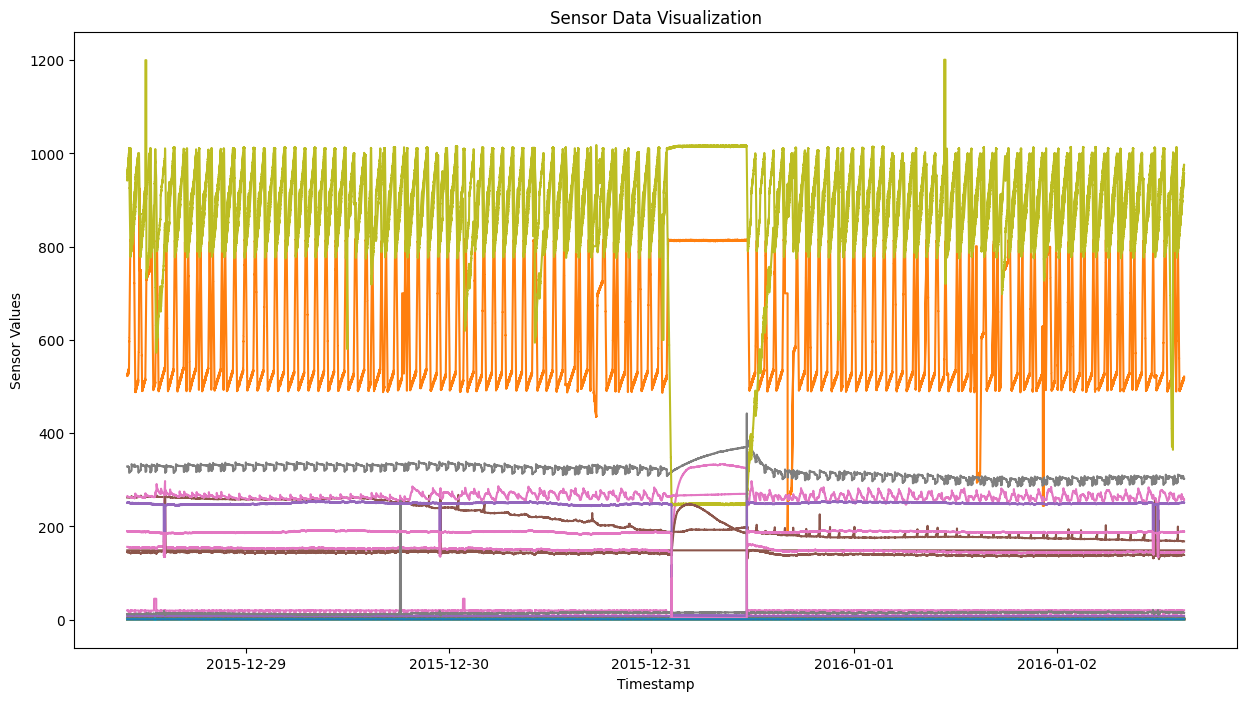

In [26]:
visualize_sensor_data(test_data)

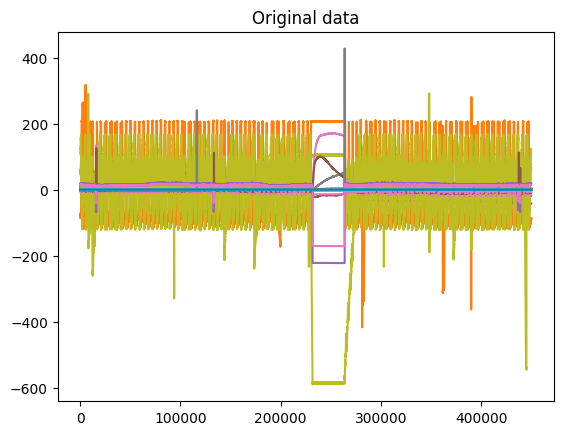

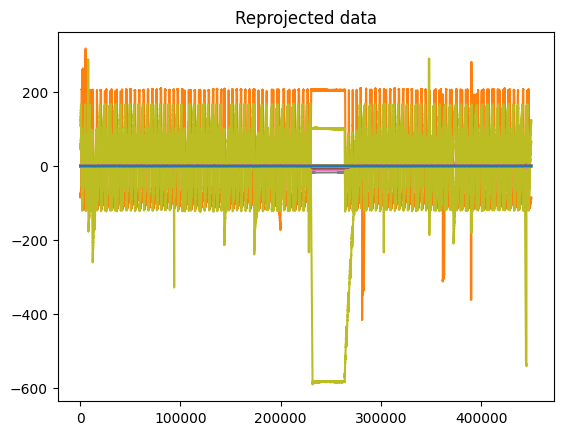

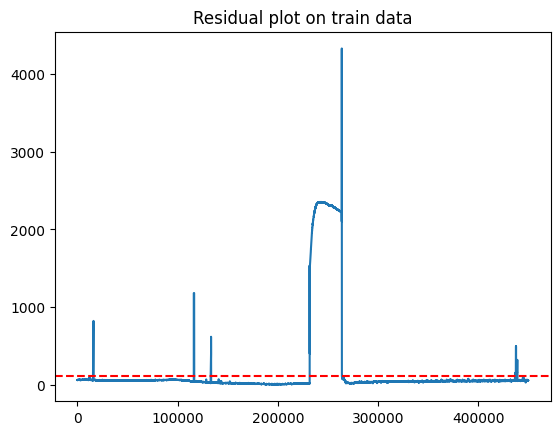

In [45]:
wo_anomalies, indices= pca_for_anomaly_detection(train_data[90_000:496_000],test_data, k=3 ,pca_threshold=120, plot_steps=True)


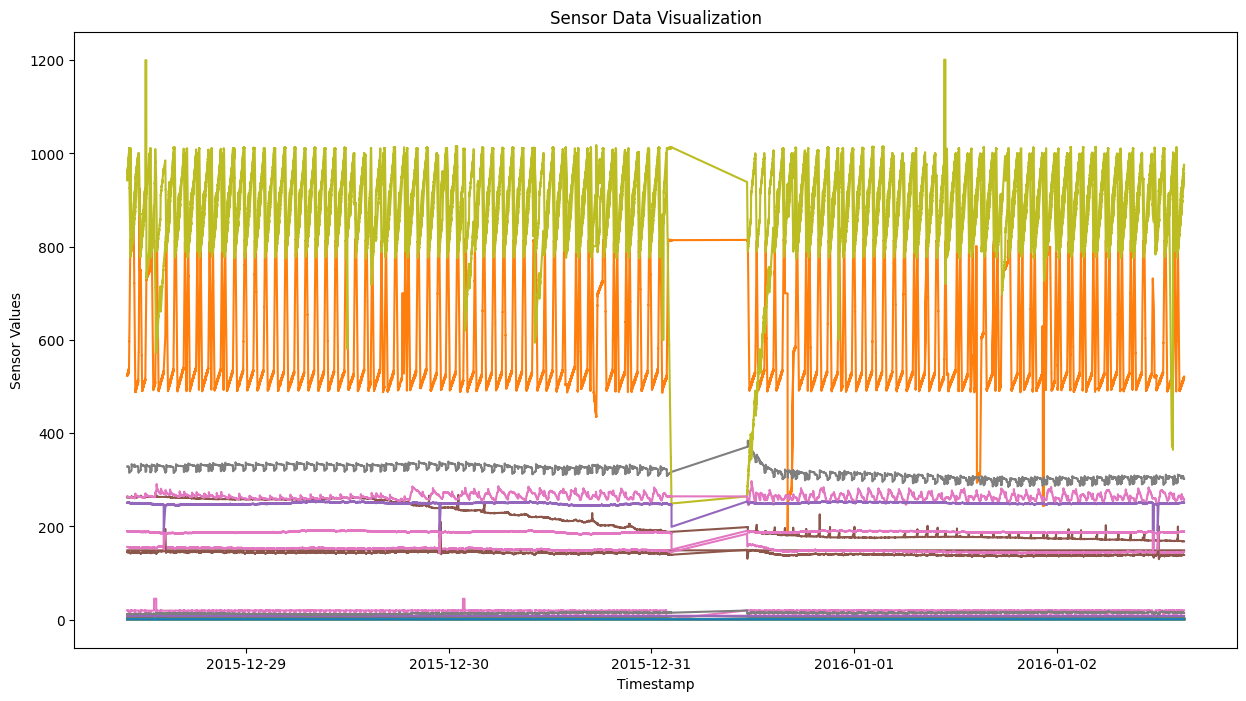

(415061, 53)

In [46]:
visualize_sensor_data(wo_anomalies)
wo_anomalies.shape

In [62]:
test_data['Normal/Attack']='Attack'
#print(test_data)
test_data.loc[indices,'Normal/Attack']='Normal'


In [63]:
test_data


,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,2015-12-28 10:00:00,2.427057,522.8467,2,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.8652,1.649953,189.5988,0.000128,1,1,1,Normal
1,2015-12-28 10:00:01,2.446274,522.886,2,2,1,262.0161,8.396437,328.6337,2.445391,...,2,1,250.8652,1.649953,189.6789,0.000128,1,1,1,Normal
2,2015-12-28 10:00:02,2.489191,522.8467,2,2,1,262.0161,8.394514,328.6337,2.442316,...,2,1,250.8812,1.649953,189.6789,0.000128,1,1,1,Normal
3,2015-12-28 10:00:03,2.53435,522.9645,2,2,1,262.0161,8.394514,328.6337,2.442316,...,2,1,250.8812,1.649953,189.6148,0.000128,1,1,1,Normal
4,2015-12-28 10:00:04,2.56926,523.4748,2,2,1,262.0161,8.394514,328.6337,2.443085,...,2,1,250.8812,1.649953,189.5027,0.000128,1,1,1,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449915,2016-01-02 14:59:56,2.549082,520.4131,2,2,1,168.0979,8.638683,301.9226,2.459488,...,2,1,251.0734,0.865024,188.9259,0.0,1,1,1,Normal
449916,2016-01-02 14:59:57,2.531467,520.6878,2,2,1,168.0979,8.638683,301.9226,2.460129,...,2,1,251.0734,0.865024,188.9259,0.0,1,1,1,Normal
449917,2016-01-02 14:59:58,2.521218,520.7271,2,2,1,168.0979,8.638683,301.9226,2.460129,...,2,1,251.0734,0.865024,188.9259,0.0,1,1,1,Normal
449918,2016-01-02 14:59:59,2.501681,521.1196,2,2,1,168.0979,8.638683,301.9226,2.458206,...,2,1,251.0734,0.865024,188.9259,0.0,1,1,1,Normal


In [64]:
temp = test_data['Normal/Attack']
temp

0                Normal
1                Normal
2                Normal
3                Normal
4                Normal
                  ...  
449915           Normal
449916           Normal
449917           Normal
449918           Normal
Normal/Attack    Attack
Name: Normal/Attack, Length: 449920, dtype: object

In [60]:
temp = temp.rename('Label')
temp

0                Normal
1                Normal
2                Normal
3                Normal
4                Normal
                  ...  
449915           Normal
449916           Normal
449917           Normal
449918           Normal
Normal/Attack    Attack
Name: Label, Length: 449920, dtype: object

In [66]:
temp.to_csv('data2.csv',index=True)